# Locality Sensitive Hashing

http://web.stanford.edu/class/cs168/p2.pdf

*For two vectors, x,y ∈ Rk that form an angle of angle(x,y) = θ < π/2 radians (i.e. x and y form an acute angle of θ), what is the probability (over the randomness in the construction of the matrix Mi) that they hash to the same bucket in this ith hash function?*

(1 - Theta/Pi) ^ d

The random vector must fall in the area where angle to u is acute, and to v is obtuse, or vice versa. Easy to see geometrically.

In [1]:
import csv
import numpy as np

NUM_WORDS = 61067
NUM_ARTICLES = 1000
NUM_GROUPS = 20

articles = np.zeros(shape=(NUM_ARTICLES, NUM_WORDS))
article_groups = []
group_articles = []
for i in range(NUM_GROUPS):
    group_articles.append([])
    
with open('data/p2/data50.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        article = int(row[0]) - 1
        word = int(row[1]) - 1
        count = int(row[2])
        articles[article][word] = count

with open('data/p2/groups.csv') as file:
    groups = [l.strip() for l in file.readlines()]

with open('data/p2/label.csv') as file:
    article = 0
    for line in file:
        group = int(line) - 1
        article_groups.append(group)
        group_articles[group].append(article)
        article += 1

In [2]:
import math
import scipy.spatial

res = np.zeros(shape=(len(articles), len(articles)), dtype=float)

def get_hash(matrix, x):
    res = 0
    mult = 1
    for v in np.matmul(matrix, x):
        cur = 1 if v > 0 else 0
        res += cur * mult
        mult *= 2
    return res

def get_hashes(matrices, x):
    return [get_hash(m, x) for m in matrices]

def preprocess(matrices, data, d):
    buckets = []
    for _ in range(len(matrices)):
        r = [[] for _ in range(2 ** d)]
        buckets.append(r)
    for i, row in enumerate(data):
        for hash_id, h in enumerate(get_hashes(matrices, row)):
            buckets[hash_id][h].append(i)
    return buckets

def get_nearest(matrices, buckets, data, xid):
    hashes = get_hashes(matrices, data[xid])
    best, bestdist = None, 0
    num_matches = 0
    for hash_id, h in enumerate(hashes):
        matches = buckets[hash_id][h]
        #print(f"hashid={hash_id}, hash={h}, matches={matches}")        
        for match in matches:
            if match != xid:
                num_matches += 1
                if res[xid][match] > 0:
                    dist = res[xid][match]
                else:
                    dist = scipy.spatial.distance.cosine(data[xid], data[match])
                    res[xid][match] = dist
                if best is None or dist < bestdist:
                    best = match
                    bestdist = dist
    return (best, num_matches)

def get_matrices(d, l):
    res = []
    for _ in range(l):
        res.append(np.random.normal(0, 1, size=(d, NUM_WORDS)))
    return res

nearests = {}
for d in range(5, 21):
    print(f"Processing d={d}")
    print("Getting matrices")
    matrices = get_matrices(d=d, l=128)
    print("Preprocessing")
    buckets = preprocess(matrices, articles, d=d)
    print("Finding nearest articles")
    nearests[d] = []
    for aid in range(len(articles)):
        if aid % 100 == 0:
            print(f"Article {aid}")
        nearests[d].append(get_nearest(matrices, buckets, articles, aid))

Processing d=5
Getting matrices
Preprocessing
Finding nearest articles
Article 0
Article 100
Article 200
Article 300
Article 400
Article 500
Article 600
Article 700
Article 800
Article 900
Processing d=6
Getting matrices
Preprocessing
Finding nearest articles
Article 0
Article 100
Article 200
Article 300
Article 400
Article 500
Article 600
Article 700
Article 800
Article 900
Processing d=7
Getting matrices
Preprocessing
Finding nearest articles
Article 0
Article 100
Article 200
Article 300
Article 400
Article 500
Article 600
Article 700
Article 800
Article 900
Processing d=8
Getting matrices
Preprocessing
Finding nearest articles
Article 0
Article 100
Article 200
Article 300
Article 400
Article 500
Article 600
Article 700
Article 800
Article 900
Processing d=9
Getting matrices
Preprocessing
Finding nearest articles
Article 0
Article 100
Article 200
Article 300
Article 400
Article 500
Article 600
Article 700
Article 800
Article 900
Processing d=10
Getting matrices
Preprocessing
Finding 

In [3]:
classification_acc = []
avg_inspected = []
for d in range(5, 21):
    matches = 0
    inspected = 0
    nomatches = 0
    for i in range(NUM_ARTICLES):
        true_group = article_groups[i]
        nearest, arts_inspected = nearests[d][i]
        if nearest is None:
            nomatches += 1
            continue
        nearest_group = article_groups[nearest]
        if true_group == nearest_group:
            matches += 1
        inspected += arts_inspected
    acc = matches / NUM_ARTICLES
    insp = inspected / NUM_ARTICLES
    nom = nomatches / NUM_ARTICLES
    print(f'd={d}, accuracy={acc}, inspected={insp}, nomatches={nom}')
    classification_acc.append(acc)
    avg_inspected.append(insp)
    
classification_acc = np.array(classification_acc)
avg_inspected = np.array(avg_inspected)

d=5, accuracy=0.456, inspected=11854.628, nomatches=0.0
d=6, accuracy=0.456, inspected=7773.638, nomatches=0.0
d=7, accuracy=0.455, inspected=4793.55, nomatches=0.0
d=8, accuracy=0.456, inspected=2778.684, nomatches=0.0
d=9, accuracy=0.454, inspected=1942.578, nomatches=0.0
d=10, accuracy=0.446, inspected=1468.898, nomatches=0.0
d=11, accuracy=0.435, inspected=891.316, nomatches=0.0
d=12, accuracy=0.424, inspected=572.814, nomatches=0.0
d=13, accuracy=0.404, inspected=375.07, nomatches=0.0
d=14, accuracy=0.389, inspected=274.47, nomatches=0.0
d=15, accuracy=0.376, inspected=168.036, nomatches=0.0
d=16, accuracy=0.366, inspected=120.674, nomatches=0.004
d=17, accuracy=0.343, inspected=78.762, nomatches=0.009
d=18, accuracy=0.323, inspected=50.778, nomatches=0.017
d=19, accuracy=0.303, inspected=46.616, nomatches=0.038
d=20, accuracy=0.277, inspected=27.732, nomatches=0.07


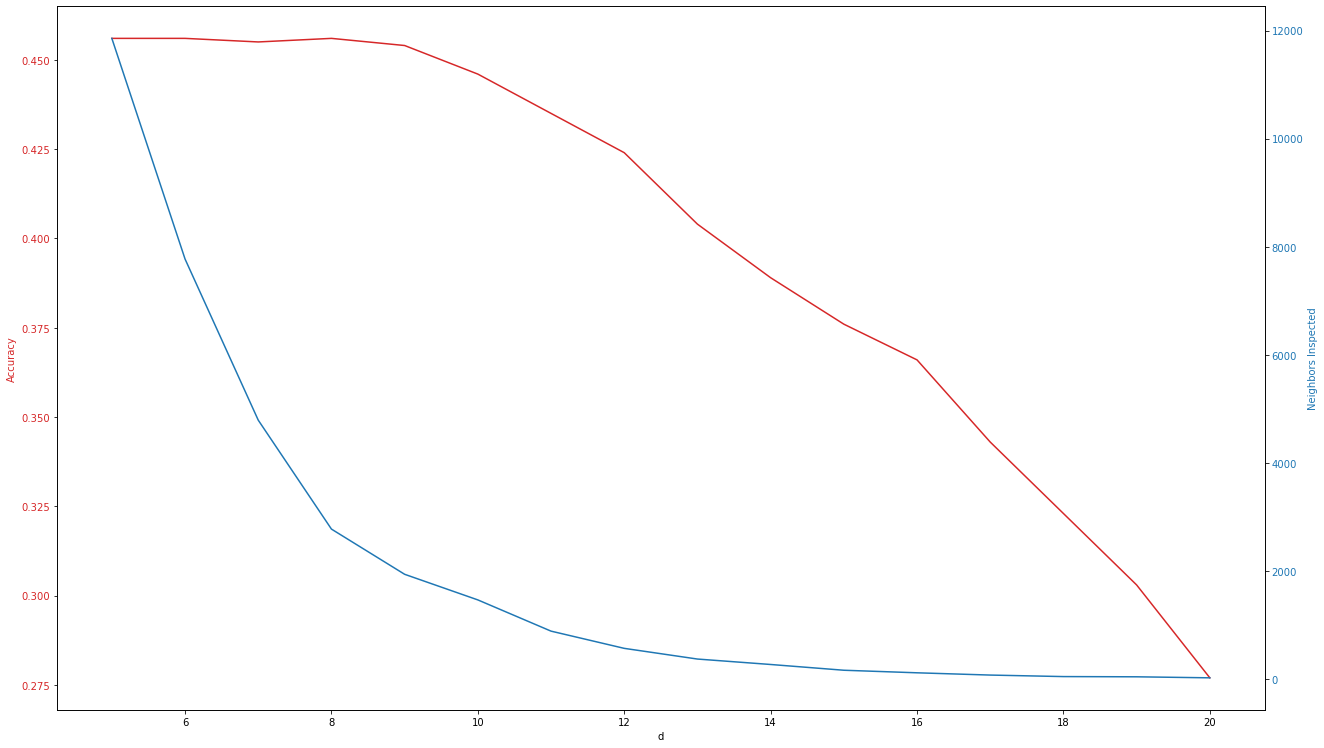

In [4]:
import matplotlib.pyplot as plt

xs = np.arange(5, 21)

fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)

color = 'tab:red'
ax1.set_xlabel('d')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(xs, classification_acc, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Neighbors Inspected', color=color)  # we already handled the x-label with ax1
ax2.plot(xs, avg_inspected, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()
plt.close()